In [1]:
%matplotlib notebook
import numpy as np
import scipy.io
import sigpy as sp
import h5py
import sigpy.plot as pl
import sigpy.mri as mr
import matplotlib.pyplot as plt

In [2]:
# labels
data_directory = '/home/nikhil/sample_data'
scan_date = '/2020-06-26_3T_8TE'


In [3]:
%%time
# load in raw k-space data
arrays = {}
f = h5py.File(data_directory + scan_date + '/kspace.mat')
for k, v in f.items():
    arrays[k] = np.array(v)
kspace = np.array(list(arrays.values()))
kspace = kspace.view(np.complex128) # convert to complex numbers

/home/nikhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 23.6 s, sys: 2.82 s, total: 26.4 s
Wall time: 26.3 s


In [4]:
# format raw k-space data (1 echo for now)

ksp = np.squeeze(kspace, axis=0)
ksp_te1 = ksp[:,1,:,:]
print('raw data array: {}'.format(kspace.shape))
print('k-space array shape: {}'.format(ksp.shape))

raw data array: (1, 32, 8, 6340, 350)
k-space array shape: (32, 8, 6340, 350)


In [5]:
# load in trajectory coordinates
coord = scipy.io.loadmat(data_directory + scan_date + '/coordinates2.mat')
coord = coord['ktraj']
coord = np.transpose(coord, (2, 1, 0))
#print('coordinate shape: {}'.format(coord.shape))


In [6]:
# load in density compensation factors
dcf = scipy.io.loadmat(data_directory + scan_date + '/dcf.mat')
dcf = dcf['dcf_all']
dcf = np.transpose(dcf, (1, 0))

# print(dcf.shape)

k-space array shape 1 TE: (32, 6340, 350)
coordinates shape: (6340, 350, 3)
dcf shape: (6340, 350)


<IPython.core.display.Javascript object>


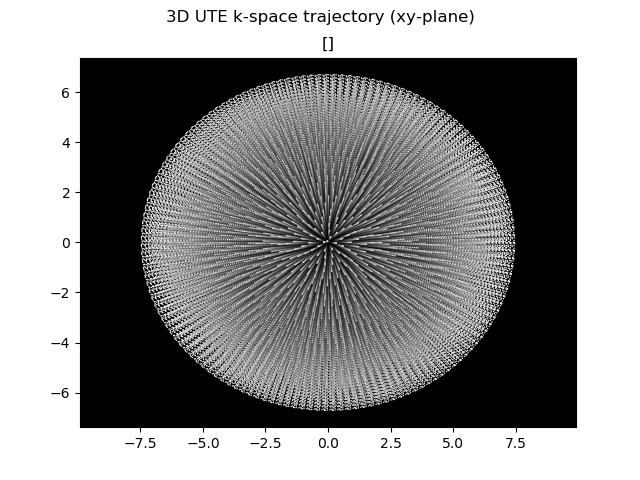

In [7]:
# check array shapes and plot k-space if desired
print('k-space array shape 1 TE: {}'.format(ksp_te1.shape))
print('coordinates shape: {}'.format(coord.shape))
print('dcf shape: {}'.format(dcf.shape))
num_ro = 100
pl.ScatterPlot(coord[:,:num_ro,[0,1]], dcf[:,:num_ro], title='3D UTE k-space trajectory (xy-plane)')


<IPython.core.display.Javascript object>


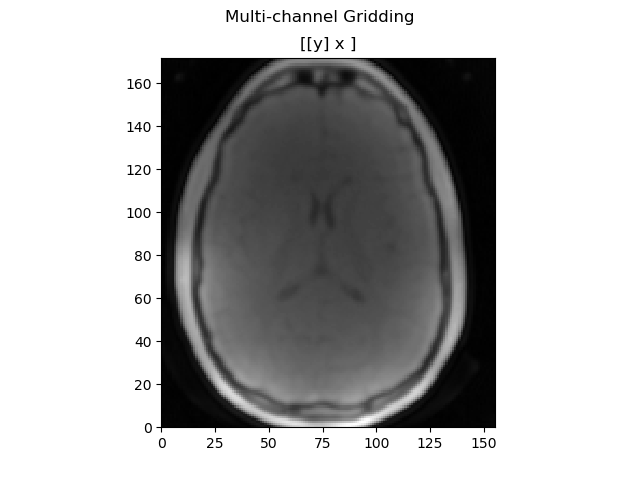

CPU times: user 7min 30s, sys: 4.74 s, total: 7min 35s
Wall time: 7min 34s


In [8]:
%%time
# multi-channel gridding reconstruction
shape = sp.estimate_shape(coord)
oversampling_ratio = 1.375
width = 5
num_channel = ksp_te1.shape[0]
num_echo = ksp.shape[1]

# perform adjoint nufft for each coil
img_coil_array = [sp.nufft_adjoint(ksp_te1[n,:,:] * dcf, coord, shape, oversampling_ratio, width)
            for n in range(num_channel)]

# reconstructed volumes from each coil
img_coil = np.stack(img_coil_array, axis=0) 

# combine coil images with rss
img_grid = np.sum(np.abs(img_coil)**2, axis=0)**0.5 

pl.ImagePlot(np.flip(img_grid[:,:,85]), title='Multi-channel Gridding')

In [8]:
import cupy as cp

# specify GPU as device
device = sp.Device(0)

# convert arrays to GPU arrays
ksp_te1_gpu = sp.to_device(ksp_te1, device=device)
coord_gpu = sp.to_device(coord, device=device)
dcf_gpu = sp.to_device(dcf, device=device)

<IPython.core.display.Javascript object>


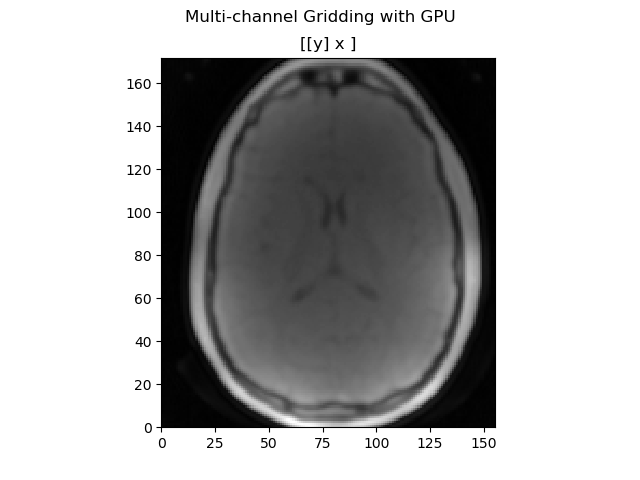

CPU times: user 4.55 s, sys: 2.49 s, total: 7.04 s
Wall time: 7.04 s


In [11]:
%%time
# Multi-channel gridding reconstruction with GPU

shape = sp.estimate_shape(coord)
oversampling_ratio = 1.375
width = 5
num_ccoils = ksp.shape[0]
num_echos = ksp.shape[1]

with device:
    # perform adjoint nufft for each coil
    img_coil_array = [sp.nufft_adjoint(ksp_te1_gpu[n,:,:] * dcf_gpu, coord_gpu, shape, oversampling_ratio, width)
                for n in range(num_ccoils)]

    # reconstructed volumes from each coil
    img_coil = cp.stack(img_coil_array, axis=0) 

    # combine coil images with rss
    img_grid = cp.sum(cp.abs(img_coil)**2, axis=0)**0.5 

pl.ImagePlot(np.flip(img_grid[:,:,85], axis=0), title='Multi-channel Gridding with GPU')


<CUDA Device 0>


<IPython.core.display.Javascript object>


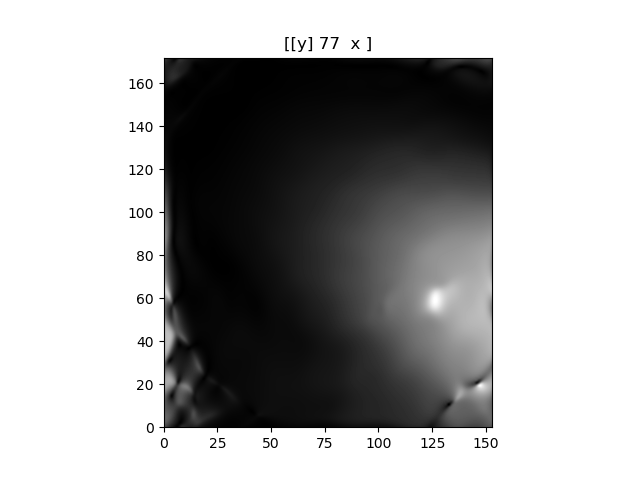

<IPython.core.display.Javascript object>


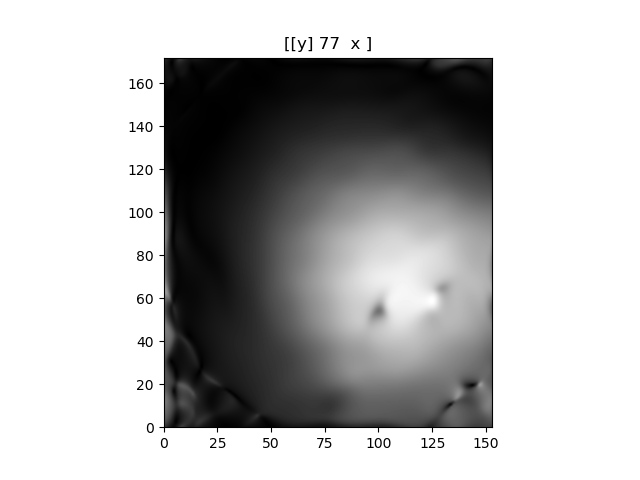

<IPython.core.display.Javascript object>


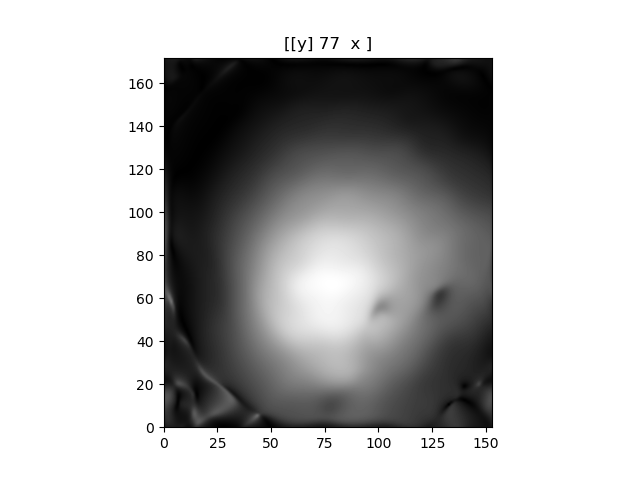

<IPython.core.display.Javascript object>


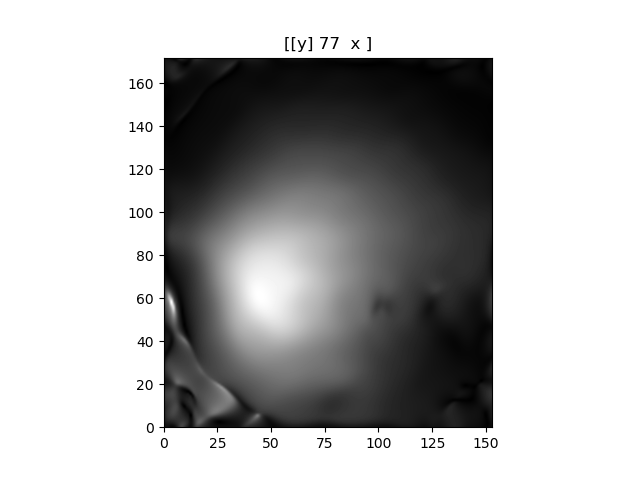

<IPython.core.display.Javascript object>


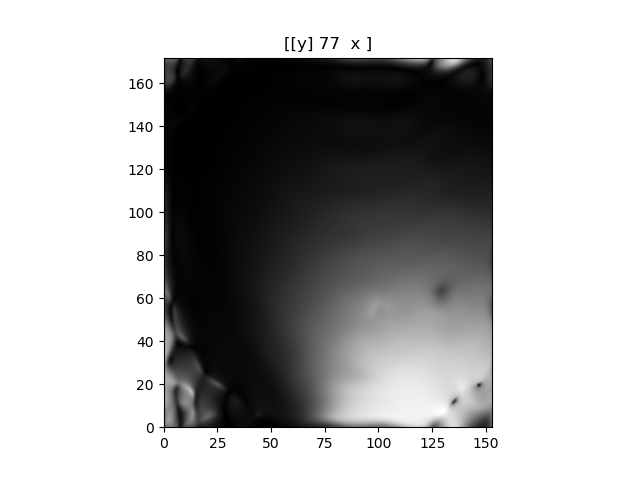

<IPython.core.display.Javascript object>


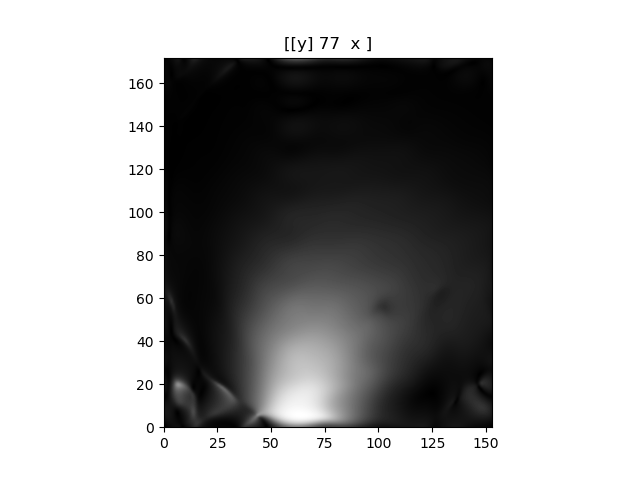

<IPython.core.display.Javascript object>


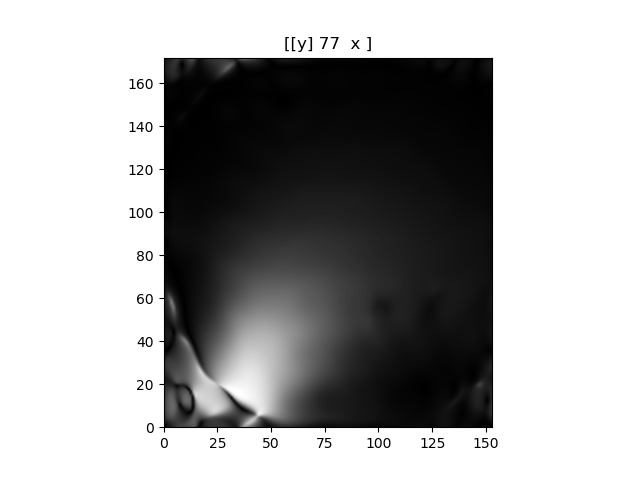

<IPython.core.display.Javascript object>


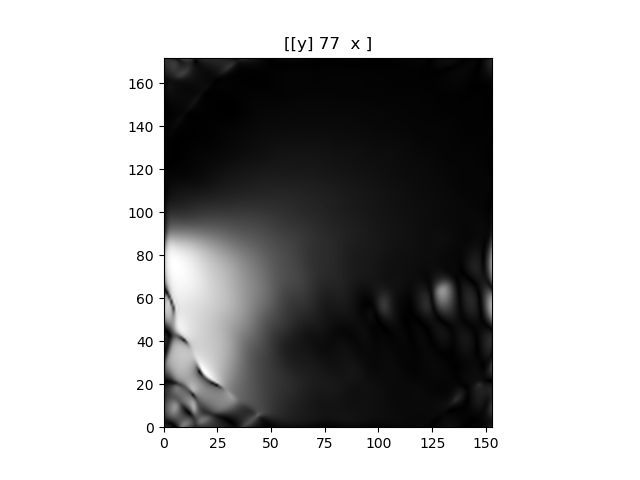

<IPython.core.display.Javascript object>


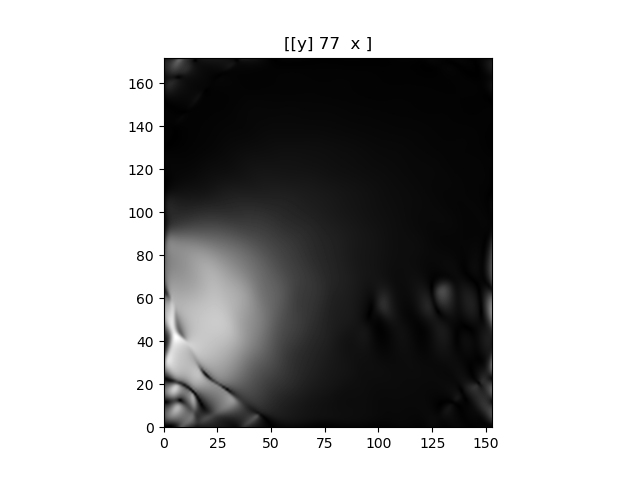

<IPython.core.display.Javascript object>


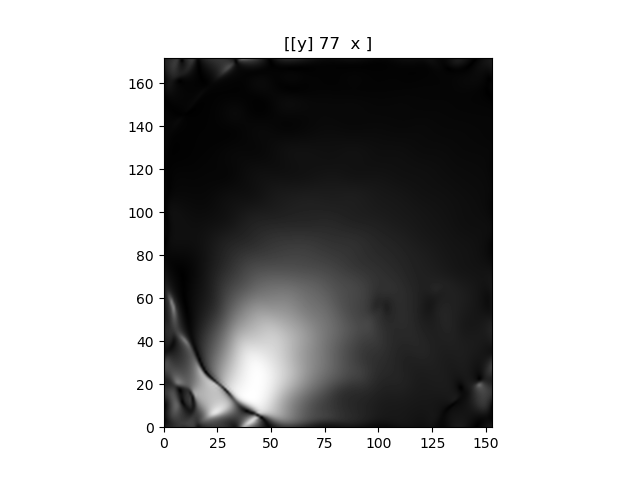

<IPython.core.display.Javascript object>


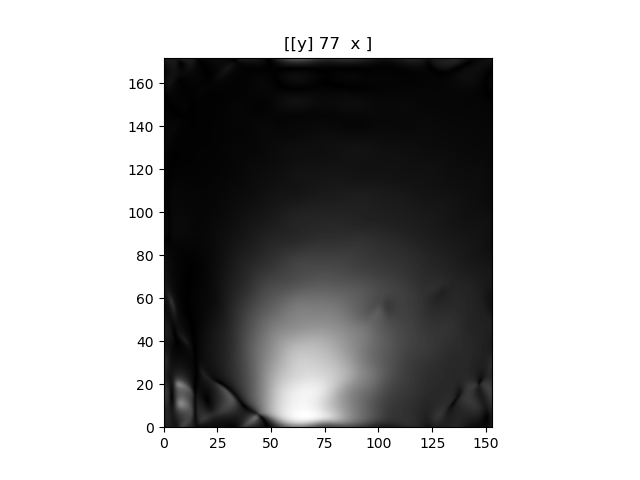

<IPython.core.display.Javascript object>


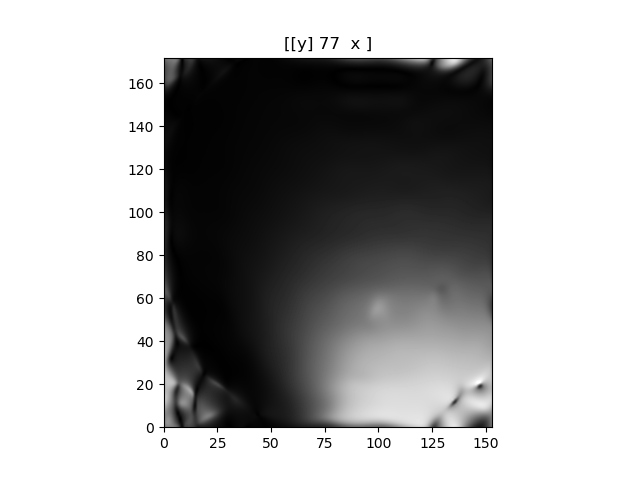

<IPython.core.display.Javascript object>


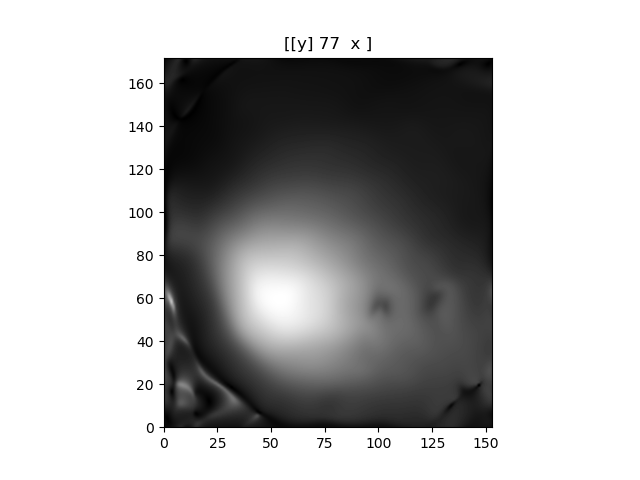

<IPython.core.display.Javascript object>


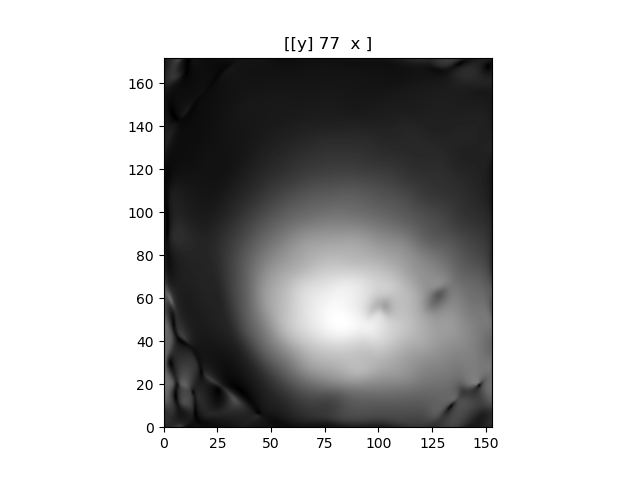

<IPython.core.display.Javascript object>


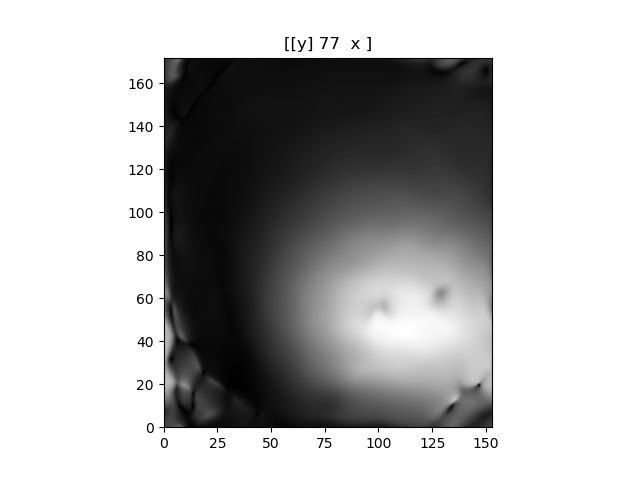

<IPython.core.display.Javascript object>


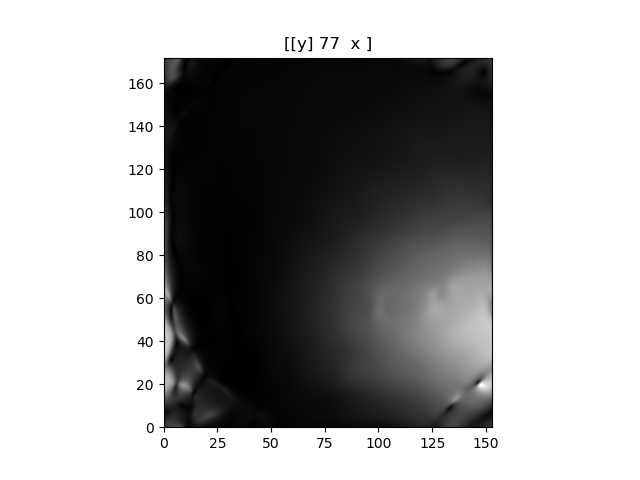

<IPython.core.display.Javascript object>


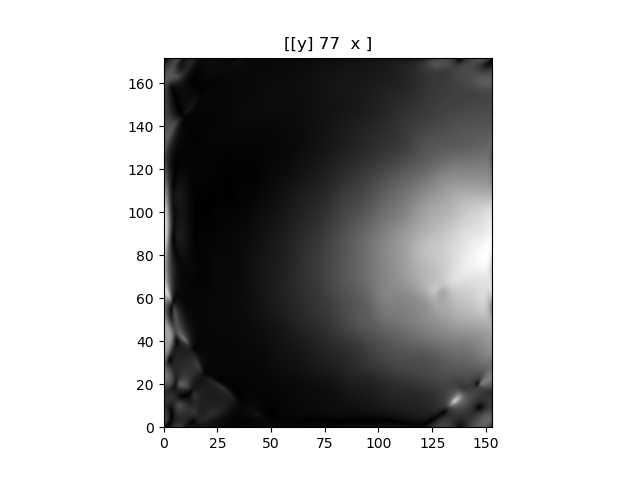

<IPython.core.display.Javascript object>


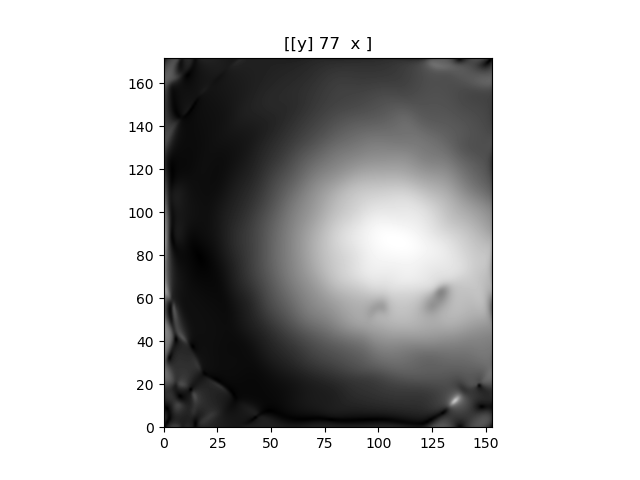

<IPython.core.display.Javascript object>


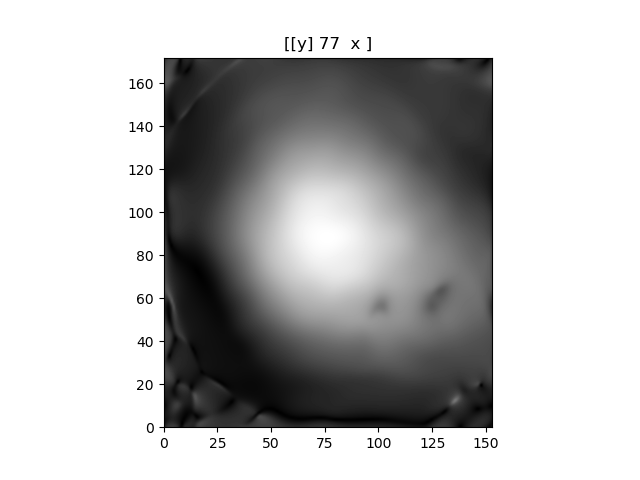

/home/nikhil/anaconda3/lib/python3.7/site-packages/sigpy/plot.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure()


<IPython.core.display.Javascript object>


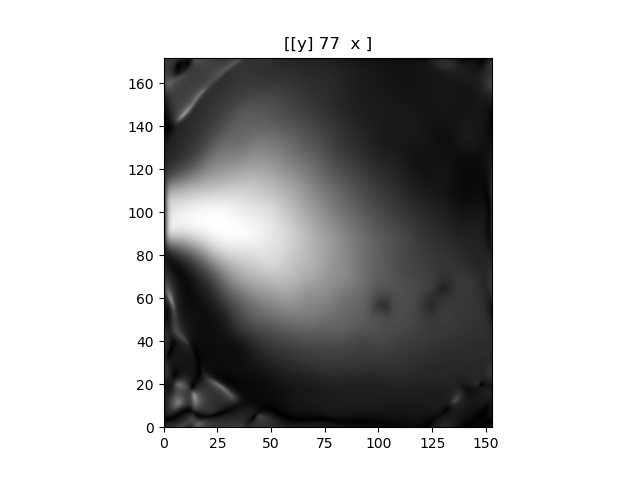

<IPython.core.display.Javascript object>


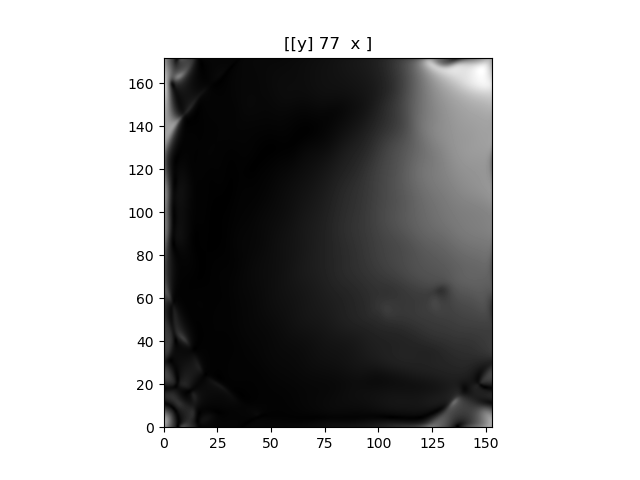

<IPython.core.display.Javascript object>


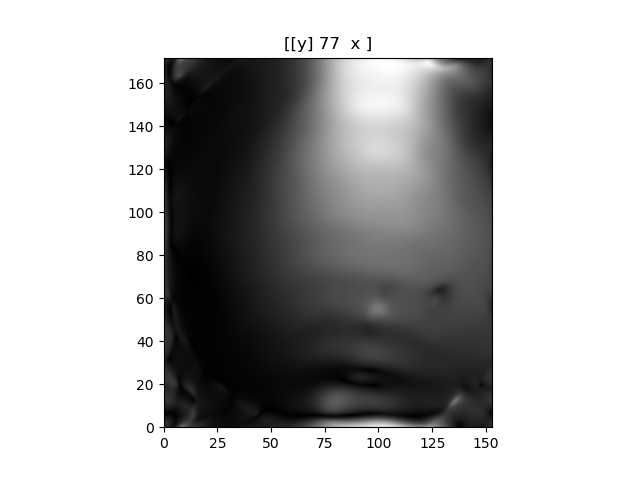

<IPython.core.display.Javascript object>


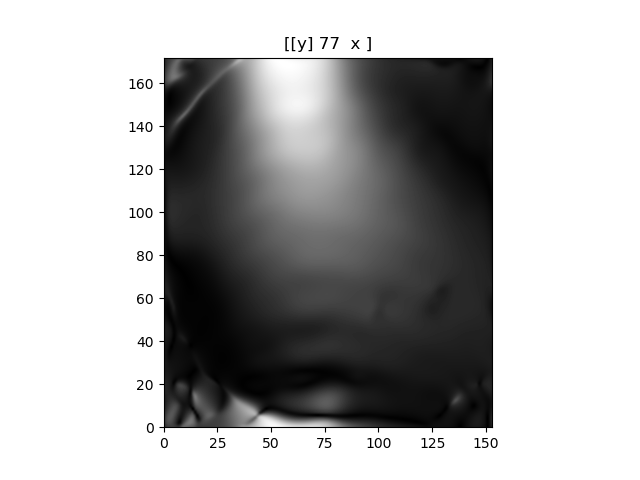

<IPython.core.display.Javascript object>


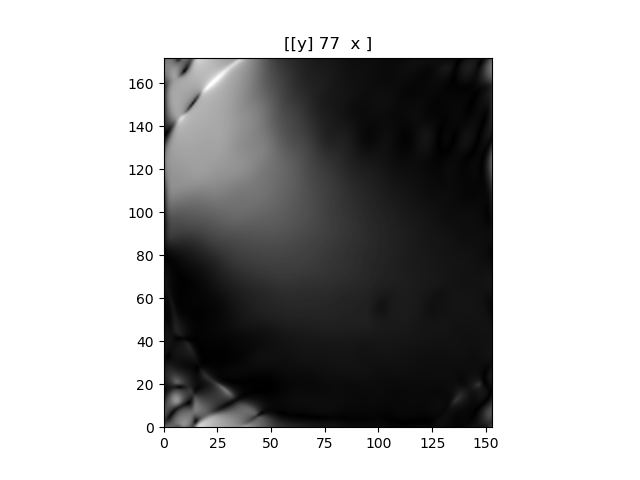

<IPython.core.display.Javascript object>


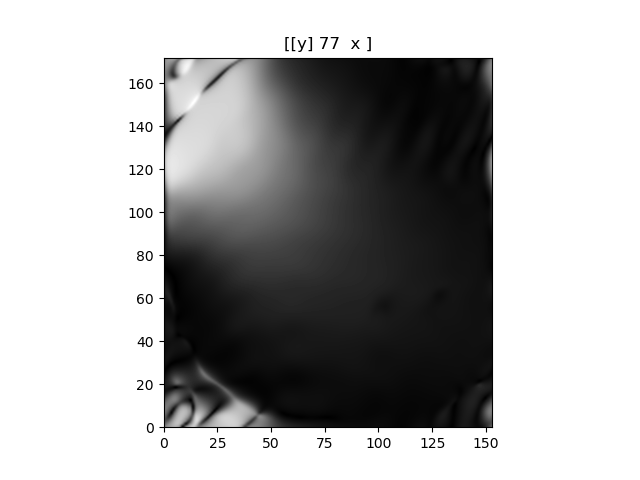

<IPython.core.display.Javascript object>


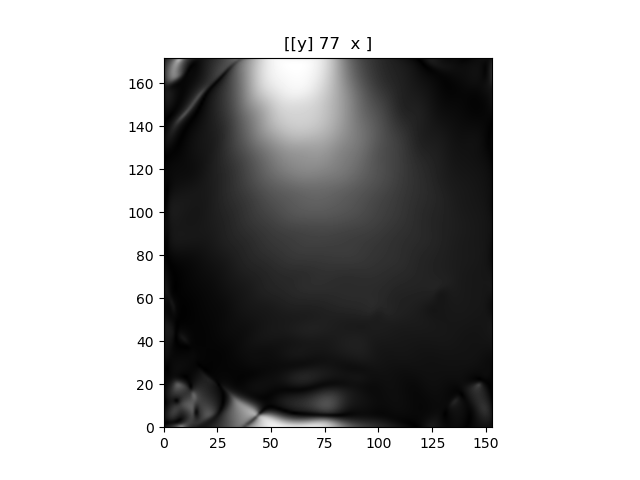

<IPython.core.display.Javascript object>


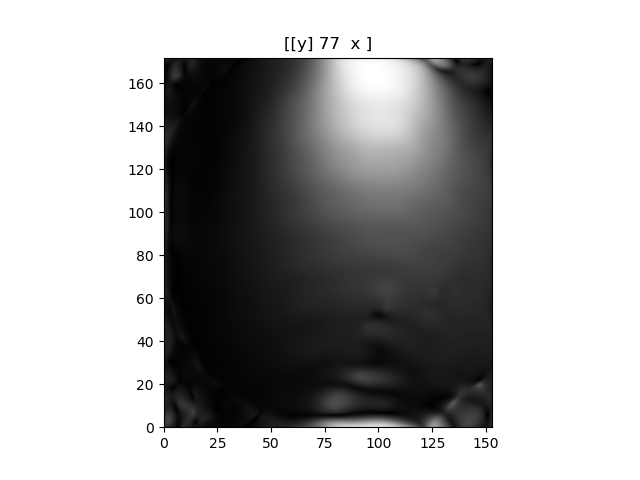

<IPython.core.display.Javascript object>


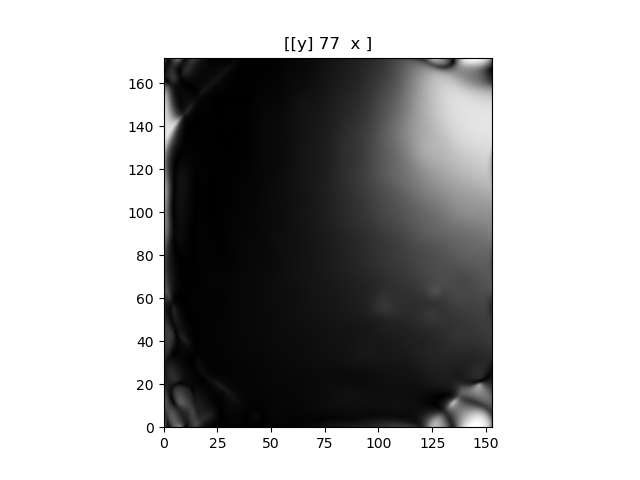

<IPython.core.display.Javascript object>


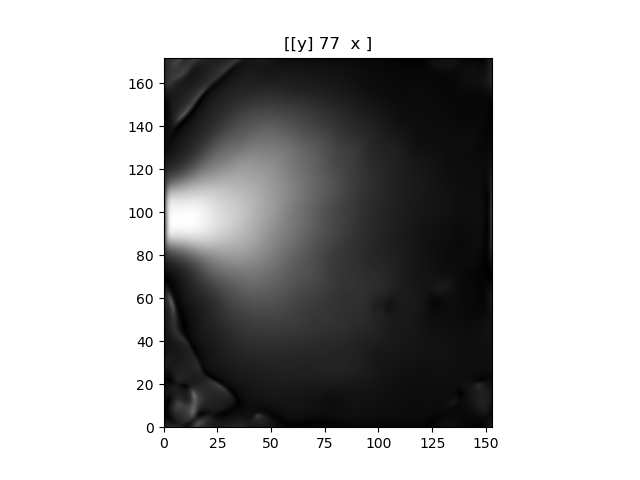

<IPython.core.display.Javascript object>


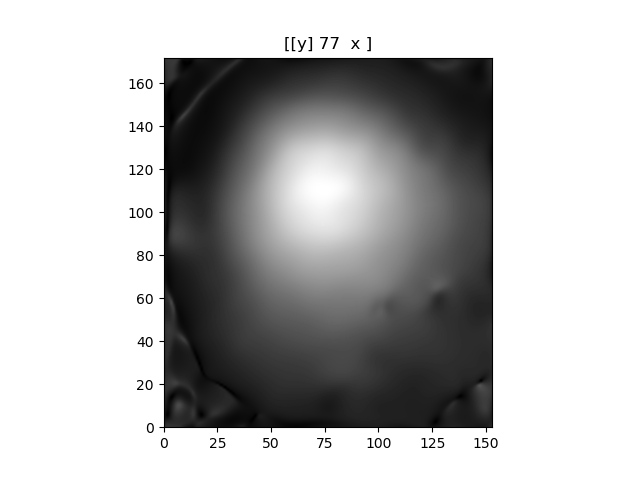

<IPython.core.display.Javascript object>


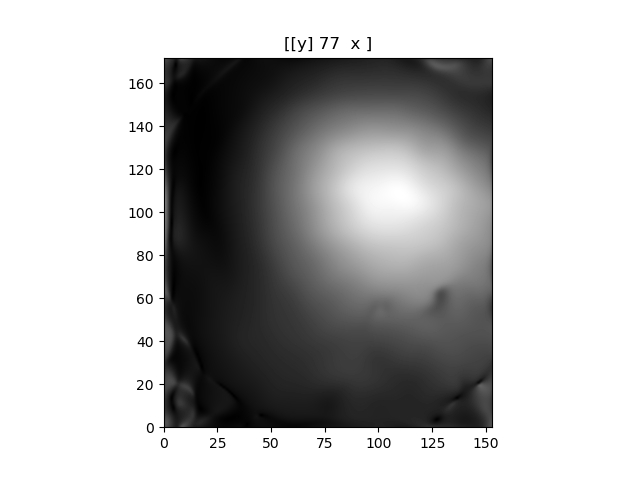

<IPython.core.display.Javascript object>


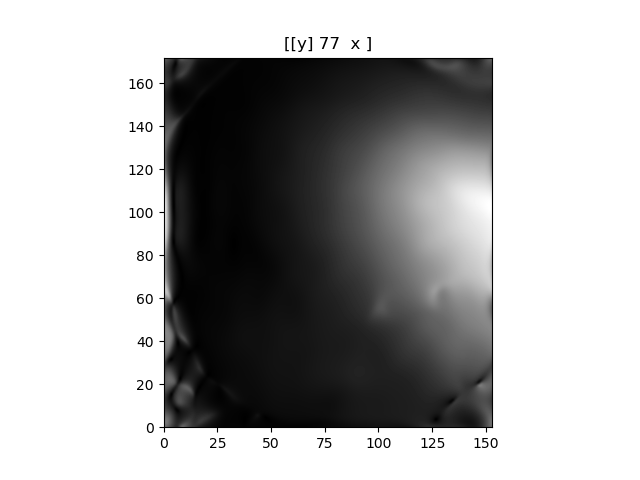

CPU times: user 1min 27s, sys: 39.7 s, total: 2min 6s
Wall time: 2min 7s


In [9]:
%%time
# Estimate sensitivity maps with JSENSE via GPU
print(device)

with device:
    mps_gpu = mr.app.JsenseRecon(ksp_te1_gpu, coord=coord_gpu, weights=dcf_gpu, device=device).run()
    
for c in range(len(mps_gpu)):
    pl.ImagePlot(mps_gpu[c, ..., ::-1], interpolation='lanczos', x=-1, y=-3)

<CUDA Device 0>


<IPython.core.display.Javascript object>


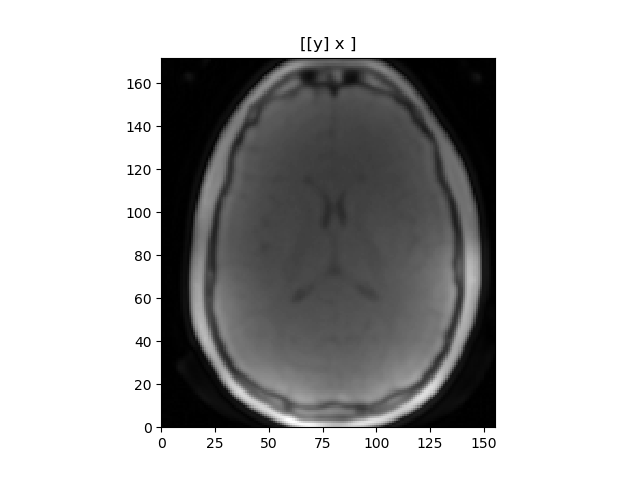

CPU times: user 1min 33s, sys: 38.1 s, total: 2min 11s
Wall time: 2min 11s


In [11]:
%%time
# SENSE reconstruction with GPU
print(device)
reg_coe = 0.01

with device:
    img_sense_gpu = mr.app.SenseRecon(ksp_te1_gpu, mps_gpu, lamda=reg_coe,
                                      weights=dcf_gpu, coord=coord_gpu, device=device).run()
    
pl.ImagePlot(np.flip(img_sense_gpu[:,:,85], axis=0))